## Importing and Cleaning

#### Running all the videos - classifying objects - and pickle object_id of vehicles and pedestrains

In [155]:
import pandas as pd
import sqlite3
from pandas.io.sql import read_sql
from sqlalchemy import create_engine
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#Get files from directory:
import os
import timeit

#Data Manipulation
import pandas as pd
import numpy as np
import os
from imblearn.over_sampling import SMOTE
# import dill as pickle
import statsmodels.api as sm

#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

#Warnings
import warnings
warnings.filterwarnings("ignore")

#Machine Learning
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [33]:
def classify(max_objects, df_positions):
    veh_id=[]
    ped_id=[]
    for i in range(max_objects):
        temp=df_positions.loc[df_positions['object_id'] == i].reset_index(drop=True)
        

        x_diff = (temp['x_coordinate'][temp.shape[0]-1]-temp['x_coordinate'][0])
        y_diff = (temp['y_coordinate'][temp.shape[0]-1]-temp['y_coordinate'][0])

    #If you want to print the differences for every object, uncomment the two lines below    
    # =============================================================================
    #     print('Diff in X for '+ str(i) + ' is ' +str(x_diff))
    #     print('Diff in Y for '+ str(i) + ' is ' +str(y_diff))
    #     print('\n\n')
    # =============================================================================


        if abs(x_diff) > 15:
            veh_id.append(i)
        elif abs(y_diff) > 2:
            ped_id.append(i)
        
    return veh_id, ped_id

#x,y=classify(max_objects, df_positions)
#print x,y

In [108]:
def SQL_to_Pandas(filename):
    #=============================================================
    ## COMMENT TO PROCESS ALL THE DATABASES
    #=============================================================
    delta_t=1/30
    con = sqlite3.connect(path+filename)

    #Defining The number of objects we have
    sql_command = "SELECT COUNT(*) FROM objects"

    max_objects_sql = con.execute(sql_command)
    max_objects = max_objects_sql.fetchone()
    max_objects=max_objects[0]

    ## Using the SQL command
    # Getting the positions of every object
    df_positions = pd.read_sql_query("SELECT a.object_id,  b.frame_number, x_coordinate, y_coordinate\
    FROM objects_features AS a \
    JOIN positions AS b ON a.trajectory_id = b.trajectory_id",con)

    # Getting the velocities of every object
    df_velocities = pd.read_sql_query("SELECT a.object_id,  b.frame_number, b.x_coordinate, b.y_coordinate\
    FROM objects_features AS a \
    JOIN velocities AS b ON a.trajectory_id = b.trajectory_id",con)


    # Merging the velocities and positions
    df = pd.DataFrame()

    df=df_positions.copy()  
    df.columns = ['object', 'frame', 'x', 'y']

    #Compute the velocities:
    
#     df['v_x']=(df['x'].shift(1)-df['x'].shift(-1))/(2*delta_t)
#     df['v_y']=(df['y'].shift(1)-df['y'].shift(-1))/(2*delta_t)
#     interaction=interaction[:-1]

    #=============================================================
    
    # UNCOMMENT IF YOU WOULD LIKE TO COMPUTE THE AVERAGE OVER THE TRAJECTORIES

    df=df.groupby(['object','frame']).mean().reset_index()
    #Dropping elements with nan
    df=df.dropna(axis=0, how='any')
    
#     df['v_x_test']= abs(df['x'].shift(-1)-df['x'])/delta_t
#     df['v_y_test']= abs(df['y'].shift(-1)-df['y'])/delta_t
    
    return df,max_objects

## Pairing output

In [109]:
path = '/Users/mubarak/Downloads/Capstone_Code-master 2/SQL/2/'
[df,max_objects] = SQL_to_Pandas('clip_10.sqlite')

In [110]:
df.head()

,object,frame,x,y
0,0,0,1.753980,1.430474
1,0,1,1.383389,1.229433
2,0,2,1.191444,1.197430
3,0,3,1.062586,1.183371
4,0,4,0.931671,1.168614


In [102]:
df['v_x']= abs(df['x'].shift(-1)-df['x'])/delta_t
df['v_y']= abs(df['y'].shift(-1)-df['y'])/delta_t

In [103]:
df.head()

,object,frame,x,y,v_x_test,v_y_test
0,0,0,1.753980,1.430474,11.117729,6.031238
1,0,1,1.383389,1.229433,5.758372,0.960097
2,0,2,1.191444,1.197430,3.865715,0.421766
3,0,3,1.062586,1.183371,3.927471,0.442726
4,0,4,0.931671,1.168614,3.989509,0.453182


In [38]:
print('/Users/mubarak/Downloads/Capstone_Code-master 2/SQL/'+str(d)+'/')
print('/Users/mubarak/Downloads/Capstone_Code-master 2/SQL/2')

/Users/mubarak/Downloads/Capstone_Code-master 2/SQL/2/
/Users/mubarak/Downloads/Capstone_Code-master 2/SQL/2


In [136]:
path_interaction = "/Users/mubarak/Downloads/Capstone_Code-master 2/SQL/Interactions/"
for x in range(4):
    inter = pd.read_csv(path_interaction+str(x)+".csv")
    inter=inter.drop(['Unnamed: 0'], axis=1)
    path = '/Users/mubarak/Downloads/Capstone_Code-master 2/SQL/'+str(x)+'/'
    for i in range(len(inter.index)):
        [df, max_objects]=SQL_to_Pandas(inter.iloc[i,0]+'.sqlite')
        df['v_x']= abs(df['x'].shift(-1)-df['x'])/delta_t
        df['v_y']= abs(df['y'].shift(-1)-df['y'])/delta_t
        df=df.dropna(axis=0, how='any')

        veh_iden=int(inter.iloc[i,2])
        ped_iden=int(inter.iloc[i,1])

        vehicle=df.loc[df['object'] == veh_iden]    
        pedestrian=df.loc[df['object'] == ped_iden]

        interaction_file = pd.merge(vehicle, pedestrian, how ='inner', on = ['frame'])
        interaction_file.columns = ['object1', 'frame', 'x1', 'y1', 'v_x1', 'v_y1', 'object2', 'x2', 'y2', 'v_x2', 'v_y2']
        if i==0:
            interactions_day = interaction_file.copy()
        else:
            frames = [interactions_day, interaction_file]
            interactions_day = pd.concat(frames)
    if x==0:
        all_interactions = interactions_day.copy()
    else:
        all_interactions = pd.concat([all_interactions, interactions_day])

In [198]:
all_interactions.head()

,object1,frame,x1,y1,v_x1,v_y1,object2,x2,y2,v_x2,v_y2
0,21,220,16.084079,2.468011,1.738851,3.587110,11,13.095978,2.492506,0.049180,0.763525
1,21,221,16.026117,2.348440,2.814839,5.197024,11,13.094339,2.517957,0.449131,1.815267
2,21,222,16.119945,2.521674,1.046933,0.493216,11,13.109310,2.578465,0.390401,1.155908
3,21,223,16.085047,2.505234,1.080118,1.670824,11,13.096296,2.616996,0.041256,0.783199
4,21,224,16.049043,2.449540,0.624722,0.523641,11,13.094921,2.643102,0.717335,1.483003


In [138]:
all_interactions.shape

(8001, 11)

## Careful, the velocities are off! Better calculate them manually to get real brake/Not brake output

In [139]:
# calculate relative 
MLInput = pd.DataFrame()
MLInput['frame'] = all_interactions['frame']
MLInput['relative_X'] = all_interactions['x1'] - all_interactions['x2']
MLInput['relative_Y'] = all_interactions['y1'] - all_interactions['y2']
MLInput['relative_Vx'] = all_interactions['v_x1'] - all_interactions['v_x2']
MLInput['relative_Vy'] = all_interactions['v_y1'] - all_interactions['v_y2']
MLInput['brake'] = 0
#MLInput.columns = ['frame','relative_X','relative_Y','relative_Vx','relative_Vy','brake']


for frame in all_interactions['frame']:
    if len(all_interactions.loc[all_interactions['frame']==frame-1]['v_x1'].values)>0: 
        v_prev = all_interactions.loc[all_interactions['frame']==frame-1]['v_x1'].values[0]
        v = all_interactions.loc[all_interactions['frame']==frame]['v_x1'].values[0]
        if v - v_prev < 0:
            MLInput.loc[MLInput['frame']==frame,'brake'] = 1
        
MLInput.head()
MLInput.to_csv("Input1")

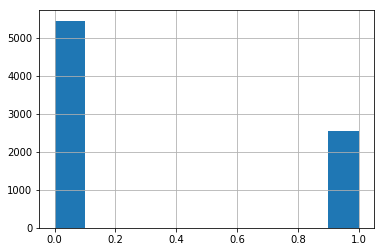

In [140]:
MLInput.brake.hist()

In [142]:
MLInput.head()

,frame,relative_X,relative_Y,relative_Vx,relative_Vy,brake
0,220,2.988101,-0.024495,1.689670,2.823586,1
1,221,2.931778,-0.169516,2.365708,3.381757,0
2,222,3.010635,-0.056791,0.656532,-0.662692,1
3,223,2.988751,-0.111762,1.038862,0.887625,0
4,224,2.954122,-0.193562,-0.092613,-0.959363,1


In [144]:
## Features: Angle, derivative of angle, time to pedestrian
delta_time=30 #seconds

MLInput2 = pd.DataFrame()
Intermediate = pd.DataFrame()

Intermediate['direction']=(MLInput['relative_Vx']>=0).astype(int)+ (MLInput['relative_Vx']<0).astype(int)*(-1)
Intermediate['X_r']=MLInput['relative_X']*Intermediate['direction'] # Check the direction though!
Intermediate['Y_r']=MLInput['relative_Y']*Intermediate['direction']

#Create the new features
MLInput2['alpha']=np.abs(np.arctan2(Intermediate['Y_r'],Intermediate['X_r']))*180/np.pi
MLInput2['delta_alpha']=(MLInput2['alpha'].shift(1)-MLInput2['alpha'])/delta_time
MLInput2['tt_ped']=abs(MLInput['relative_X']/all_interactions['v_x1'])
MLInput2['brake']=MLInput['brake']
MLInput2=MLInput2.dropna(axis=0, how='any')

#changing all the data for when the angle alpha is >90 degree
#MLInput2['brake']=MLInput2['brake']*(MLInput2['alpha']<90).astype(int)
MLInput2.to_csv("Input2")

In [199]:
MLInput2.head()

,alpha,delta_alpha,tt_ped,brake
1,3.309171,-0.094650,1.041544,0
2,1.080667,0.074283,2.875671,1
3,2.141527,-0.035362,2.767060,0
4,176.251176,-5.803655,4.728698,1
5,4.370496,5.729356,1.266017,0


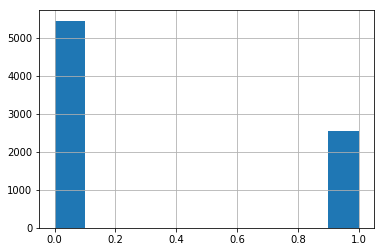

In [200]:
MLInput.brake.hist()

In [146]:
#The functions given below are used to generate metrics for the trained model

def roc_model(y_true, y_score, n_classes):
    """This function plots the ROC curve using TPR and FPR for various thresholds and finally displays the
    the Area Under the Curve (AUC)  
    
    Input - Array of true labels, array of probabilities for positive class, and number of classes to classify
    Output - ROC Curve and AUC of the model"""
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_true, y_score[:,i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    print('The AUC for the car braking (positive class or class 1) is ',roc_auc[1])
    print('\n')
    plt.figure()
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) for class 1 (Car Braking)')
    plt.legend(loc="lower right")
    plt.show()  

def conf_matrix(y_true,y_pred):
    """This function displays the confusion matrix of the model along with the classification report
    with useful metrics such as recall and f-score 
    
    Input - Array of true labels and an array of predicted labels
    Output - Classification report with metrics and confusion matrix"""
    
    print(metrics.classification_report(y_true,y_pred))
    print('\n \n')
    labels = [0, 1]
    cm = metrics.confusion_matrix(y_true,y_pred,labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
def feature_importance(x_train,trained_model,number_of_features):
    """This function plots the feature_importance that model has assigned to each independent variable in our
    model and displays it in descending using a bar chart
    
    Input - Training Dataframe of features alone, the trained model itself (estimator), the number of top features
            we want to see on the bar chart
    Output - A bar chart with the selected number of features ranked in descending order"""
    
    feats = {}
    for feature, importance in zip(x_train.columns, trained_model.best_estimator_.feature_importances_):
        feats[feature] = importance 
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Feature-importance'})
    sorted_imp = importances.sort_values(by='Feature-importance', ascending = False)
    sorted_imp.head(number_of_features).plot(kind='bar', rot=40, figsize = (15,5))
    print('THE RANKING OF THE FEATURES BASED ON \nIMPORTANCE IN PREDICTING BOOKINGS:')

In [156]:
#This step separates the features and the target column which in our case is the booked column
X = MLInput2.iloc[:,:-1]
Y = MLInput2.iloc[:,-1:]

In [157]:
# Split data into training and validation set  using sklearn function

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print ('Number of samples in training data:',len(x_train))
print ('Number of samples in validation data:',len(x_test))

('Number of samples in training data:', 6400)
('Number of samples in validation data:', 1600)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1154fa910>]],
      dtype=object)

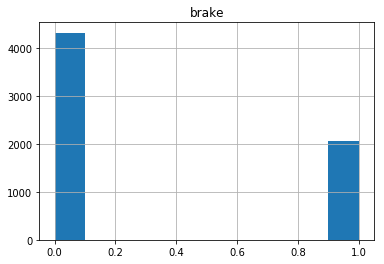

In [188]:
y_train.hist()

In [191]:
"""Fixing CLASS IMBALANCE (there is very less data for '1' booked label) by oversampling from the minority class,
making the ratio 1:2 from an earlier 1:6"""

sm = SMOTE(random_state=12, ratio = 0.75)
x_train_mod, y_train_mod = sm.fit_sample(x_train, y_train)
np.bincount(y_train_mod)

array([4330, 3247])

In [192]:
"""Choosing a Weighted Random Forest (WRF) Classifier because this is a tree-based model which can handle 
non-linearity well and also cater to one of our main objectives which is to identify the featuers that impact 
the booking likelihood the most"""

forest = RandomForestClassifier(class_weight = {0:1,1:1.2})

#The model will be tuned on the following hyperparemeters to identify the best model

param_grid = {"n_estimators" : [50, 60, 70],
             "max_depth" : [ 6, 8, 10],
             "max_leaf_nodes": [ 5, 10, 20], 
             "min_impurity_split": [0.1, 0.2, 0.3]}

#The parameters of the estimator are optimized by cross-validated grid-search over a parameter grid

random_forest = GridSearchCV(forest, param_grid=param_grid, cv=3)

In [193]:
#The model is fit on the training data and the parameters for the best estimator are printed out
random_forest.fit(x_train_mod, y_train_mod)

print("Best parameters: {}".format(random_forest.best_params_))

Best parameters: {'n_estimators': 50, 'max_leaf_nodes': 20, 'max_depth': 10, 'min_impurity_split': 0.1}


In [194]:
#This step is to print out both the train and the validation accuracy of the model
train_acc = random_forest.score(x_train_mod, y_train_mod)
test_acc = random_forest.score(x_test,y_test)

print("The training accuracy is: ", train_acc, "\n", "The validation accuracy is: ", test_acc)

('The training accuracy is: ', 0.6345519334829088, '\n', 'The validation accuracy is: ', 0.59875)


In [195]:
train_proba = random_forest.predict_proba(x_train_mod)
train_pred = random_forest.predict(x_train_mod)

test_proba = random_forest.predict_proba(x_test)
test_pred = random_forest.predict(x_test)

('The AUC for the car braking (positive class or class 1) is ', 0.5255688595071888)




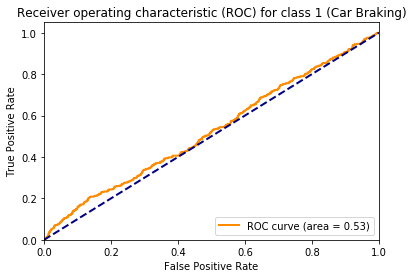

In [196]:
#This step visualizes the ROC curve and displays the AUC for class 1 which is a search ending in a booking

roc_model(y_test,test_proba,2)

             precision    recall  f1-score   support

          0       0.71      0.73      0.72      1115
          1       0.32      0.30      0.31       485

avg / total       0.59      0.60      0.59      1600


 

[[813 302]
 [340 145]]


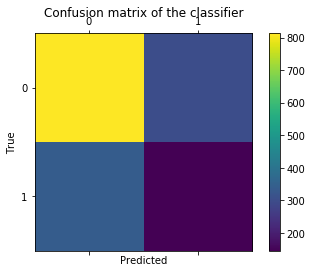

In [197]:
#This part displays the classification report (recall needs to be improved) and visualizes the confusion matrix
conf_matrix(y_test,test_pred)

THE RANKING OF THE FEATURES BASED ON 
IMPORTANCE IN PREDICTING BOOKINGS:


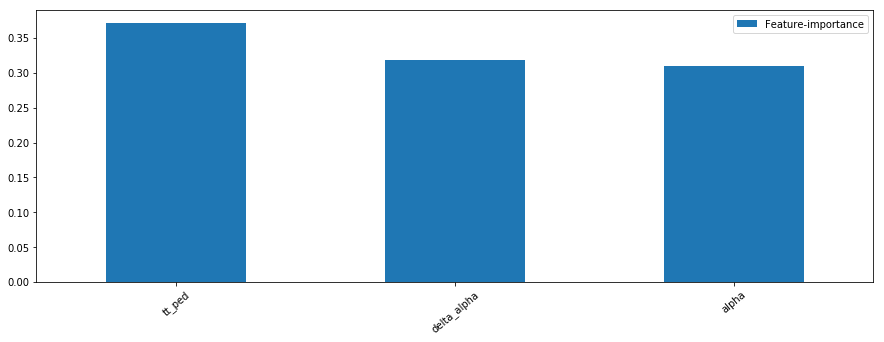

In [170]:
#Extracting Feature Importance
feature_importance(x_train,random_forest,5)